# Refractive index reconstruction script Vargas et al.

In [4]:
import pandas as pd

t_file_path = r"J:\downloads\vidrio T.Sample.ASC"
r_file_path = r"J:\downloads\vidrio R 2.ASC"

t_df = pd.read_csv(
    t_file_path,
    header=90,
    names=["wavelength", "T"],
    decimal=",",
    sep = "\t",
    dtype=float
)

r_df = pd.read_csv(
    r_file_path,
    header=90,
    names=["wavelength", "R"],
    decimal=",",
    sep = "\t",
    dtype=float
)

In [5]:
r_df["R"] = r_df["R"] /100
t_df["T"] = t_df["T"] /100

df_merged = pd.merge(r_df, t_df, on="wavelength", how="inner")

In [6]:
import pandas as pd
import numpy as np

def compute_nk(df: pd.DataFrame, h: float) -> pd.DataFrame:
    """
    Calcula los índices ópticos n y k a partir de las ecuaciones (11a)-(11c).
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame con columnas ['wavelength', 'R', 'T'].
        - wavelength en las mismas unidades que h (ej. nm o µm)
        - R, T deben estar entre [0,1]
    h : float
        Espesor de la capa (en las mismas unidades que wavelength).
    
    Returns
    -------
    pd.DataFrame
        DataFrame con columnas adicionales ['r', 'k', 'n']
    """
    
    df = df.copy()
    
    R = df["R"].to_numpy()
    T = df["T"].to_numpy()
    wavelength = df["wavelength"].to_numpy()
    
    # ---------- (11a) cálculo de r ----------
    term1 = (T**2 + 2 - (R - 1)**2) / (2 * (2 - R))
    r = term1 - np.sqrt(term1**2 - R / (2 - R))
    
    # ---------- (11b) cálculo de k ----------
    # Evitamos log de negativo con clip
    ratio = (R - r) / (r * T)
    ratio = np.clip(ratio, 1e-20, None)
    k = -(wavelength / (4 * np.pi * h)) * np.log(ratio)
    
    # ---------- (11c) cálculo de n ----------
    frac = (1 - r) / (1 + r)
    inside_sqrt = 1 - (frac**2) * (1 + k**2)
    inside_sqrt = np.clip(inside_sqrt, 0, None)  # evitar negativos por redondeo
    n = (1 + r) / (1 - r) * (1 + np.sqrt(inside_sqrt))
    
    # Guardamos resultados en el DataFrame
    df["r"] = r
    df["k"] = k
    df["n"] = n
    
    return df


# ================== EJEMPLO ==================

h = 1_000_000  # espesor en nm
result = compute_nk(df_merged, h)

print(result)


      wavelength         R         T         r         k         n
0         1482.0  0.114076  0.926141  0.058105 -0.000005  1.635215
1         1481.0  0.114253  0.924243  0.058300 -0.000004  1.636626
2         1480.0  0.115811  0.925515  0.058977 -0.000005  1.641492
3         1479.0  0.114931  0.925760  0.058539 -0.000005  1.638340
4         1478.0  0.115495  0.928383  0.058656 -0.000005  1.639186
...          ...       ...       ...       ...       ...       ...
1228       254.0  0.099155  0.019897  0.099107  0.000075  1.918909
1229       253.0  0.101668  0.020493  0.101615  0.000074  1.935874
1230       252.0  0.104658  0.022559  0.104592  0.000072  1.955984
1231       251.0  0.107913  0.023563  0.107838  0.000070  1.977905
1232       250.0  0.108204  0.023948  0.108126  0.000070  1.979848

[1233 rows x 6 columns]


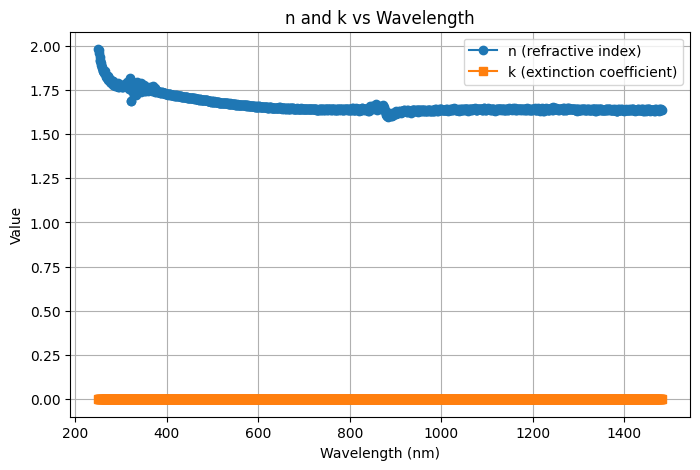

In [10]:
import matplotlib.pyplot as plt
# Plot
df_result = result
plt.figure(figsize=(8,5))
plt.plot(df_result["wavelength"], df_result["n"], marker="o", label="n (refractive index)")
plt.plot(df_result["wavelength"], df_result["k"], marker="s", label="k (extinction coefficient)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Value")
plt.title("n and k vs Wavelength")
plt.legend()
plt.grid(True)
plt.show()